**Zhang-Paxton Global Auroral Boundary - Python 2.7 Implementation**  

This script runs on Python 2.7. It also requires the numpy and matplotlib packages to be installed and ready to use. PUT IN JUSTIFICATIONS FOR CHOOSING BETWEEN SIGERNES AND ZHANG PAXTON

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

Choose the desired KP here. 

In [13]:
KP = 5 #set the desired kp 

# List of functions

**latlt2polar()**, created by Liam Kilcommons, converts an array of latitude and local time points to polar for a top-down dialplot (latitude in degrees, LT in hours) i.e. makes latitude the radial quantity and MLT the azimuthal. It also gets the radial displacement (referenced to down from northern pole if we want to do a top down on the north or up from south pole if visa-versa).
  

In [14]:
def latlt2polar(lat,lt,hemisphere): #Liam made this

    from numpy import pi
    if hemisphere=='N':
        r = 90.-lat
    elif hemisphere=='S':
        r = 90.-(-1*lat)
    else:
         raise ValueError('%s is not a valid hemisphere, N or S, please!' % (hemisphere))
    #convert lt to theta (azimuthal angle) in radians
    theta = lt/24. * 2*pi

    #the pi/2 rotates the coordinate system from
    #theta=0 at negative y-axis (local time) to
    #theta=0 at positive x axis (traditional polar coordinates)
    return r,theta

The function **kpInts()** takes kp as an argument and returns the appropriate kp intervals and their respective regression coefficients. *km* is the representative kp value of the kp bin that the desired kp is found in, while *coeffData* is a 2d array of the coefficients of that particular kp bin found in the appendix of the Zhang-Paxton paper. *kmPlus* is the representative kp value of the succeeding kp bin and *coeffDatam1* is that the coefficient set of the *kmPlus* bin. There is an edge case for when the *km* is the last kp bin in which case *kmPlus* is simply the same as *km*. 


In [15]:
def kpInts(kp):
    """
    This function determines which coefficients should be used according to the set kp intervals. 
    """
    #do it by kp interval 
    coeffKP0 = np.loadtxt('zhangpaxtoncoeffKP0.txt')
    coeffKP1_5 = np.loadtxt('zhangpaxtoncoeffKP1_5.txt')
    coeffKP3 = np.loadtxt('zhangpaxtoncoeffKP3.txt')
    coeffKP4_5 = np.loadtxt('zhangpaxtoncoeffKP4_5.txt')
    coeffKP6 = np.loadtxt('zhangpaxtoncoeffKP6.txt')
    coeffKP8 = np.loadtxt('zhangpaxtoncoeffKP8.txt')
    if (kp >= 0) & (kp <1.5):
        coeffData = coeffKP0
        coeffDatam1 = coeffKP1_5
        km = 0.75
        kmPlus = 2.25
    elif (kp >= 1.5) & (kp <3):
        coeffData = coeffKP1_5
        coeffDatam1 = coeffKP3        
        km = 2.25
        kmPlus = 3.75
    elif (kp >= 3) & (kp <4.5):
        coeffData = coeffKP3
        coeffDatam1 = coeffKP4_5
        km = 3.75
        kmPlus = 5.25
    elif (kp >= 4.5) & (kp <6):
        coeffData = coeffKP4_5
        coeffDatam1 = coeffKP6
        km = 5.25
        kmPlus = 7
    elif (kp >= 6) & (kp <8):
        coeffData = coeffKP6  
        coeffDatam1 = coeffKP8
        km = 7
        kmPlus = 9
    elif (kp >= 8) & (kp <10):            
        coeffData = coeffKP6  
        coeffDatam1 = coeffKP8
        km = 7
        kmPlus = 10
    return [km, kmPlus, coeffData,coeffDatam1]


The function **coLats()** takes a kp and a single localTime as arguments. It returns an array of colatitudes (in degrees) and the flux at each of these locations. It also returns the colatitudes of poleward and equatorward boundaries according a set flux threshold, *fluxLim* of the units mW/m^2. The number of elements in the variable *colatitudes* can be increased or decreased for performance.  

In [16]:
def coLats(kp, localTime):   
    
    #stuff that we can change 
    #fluxLim = 0.1; #flux limit  
    fluxLim = 0.25; # according to the zhang-paxton
    
    colatitudes = np.linspace(0,90,1000) #make colatitudes  
    
    
    #get the intervals for that kp
    [km, kmPlus, coeffData,coeffDatam1] = kpInts(kp)
    
    #calculate fm and fm plus
    fm = (HP_func(kmPlus) - HP_func(kp))/(HP_func(kmPlus)-HP_func(km))
    fmPlus = (HP_func(kp) - HP_func(km))/(HP_func(kmPlus)-HP_func(km))

    #calculate the big A coefficients
    bigA = bigAcoeff(localTime,coeffData)
    bigAm1 = bigAcoeff(localTime,coeffDatam1)
    
    #calculate Qm for the localTIme for all colatitudes
    Qm = Qcalc(localTime,colatitudes,bigA)
    QmPlus = Qcalc(localTime,colatitudes,bigAm1)
    
    Q = np.zeros(len(colatitudes)) #allocate a 2d array for Q
    #calculate for localTIme and AL
    for i in np.arange(len(colatitudes)):
        Q[i] = Qm[i]*fm + QmPlus[i]*fmPlus #this needs to be a loop
    
    
    [poleBound,equatBound] =  bounds(Q,colatitudes,fluxLim)

    
    #find poleward and equatorward boundary
    return Q, colatitudes, poleBound, equatBound

**HP_func()** calculates the hp or auroral hemispheric power for a given KP.

In [17]:
def HP_func(KP):
    if KP <= 5:
        hp = 38.66*np.exp(0.1967*KP) - 33.99
    else:
        hp = 4.592*np.exp(0.4731*KP) + 20.47
    return hp

**bigAcoeff()** calculates the A coefficients present in page 1235 of the Zhang-Paxton paper for a particular localTime and a set of coefficients.

In [18]:
def bigAcoeff(localTime,coeffData):
    bigA = np.zeros(4)
    for i in np.arange(4):
        bigA[i] = coeffData[0,i]
        for n in np.arange(1,6):
            bPrime = coeffData[n,i]
            bPrimePrime = coeffData[n+6,i]
            bigA[i] = bigA[i] + bPrime*np.cos(np.pi * n * localTime/12) + bPrimePrime*np.sin(np.pi * n * localTime/12) # i assume the pi is to convert to radians
    return bigA

**Qcalc()** takes in the array of localTime and colatitudes, and the *bigA* coefficients from **bigAcoeff()**, and calculates the flux *Q*. 

In [19]:
def Qcalc(localTime,colatitudes,bigA): #make sure colatitudes are in degrees
    Q = np.zeros(len(colatitudes))
    for j in np.arange(len(colatitudes)):
        Q[j] = (  bigA[0] * np.exp((colatitudes[j] -bigA[1])/(bigA[2]))  )
        Q[j] = Q[j] /( (1+ np.exp((colatitudes[j] - bigA[1])/bigA[3]))**2)
    return Q

**bounds()** determines the location of the poleward and equatorward boundaries according to a flux threshold, *fluxLim*. 

In [20]:
def bounds(Q,colatitudes,fluxlim):
    Qlogic = Q > fluxlim
    latitudes = colatitudes[Qlogic]
    poleLat = latitudes[0]
    equatLat = latitudes[-1]
    return poleLat,equatLat

# Main Script

The first part of the main script calculates the flux values for a set KP. This is done by iterating through an array of the local time values. For each of these local time values, the flux or *Q* value is calculated for a range of colatitudes. 

In [10]:
#test code that calculates the Qs for the 0:00 local Time
localTime = 0;
[Q, colatitudes, poleBound, equatBound] = coLats(KP, localTime)

#allocate variables
localTimes = np.linspace(0,24,200) #array of local time values
bigQ = np.zeros((len(colatitudes),len(localTimes))) #2-d matrix of 
polewardBound = np.zeros(len(localTimes))
equatwardBound = np.zeros(len(localTimes))

#calculate the flux values and store them in the two d 
for i in np.arange(len(localTimes)):    
    bigQ[:,i],colatitudes,polewardBound[i],equatwardBound[i] =  coLats(KP,localTimes[i])

The rest of this script simply creates and formats the contour plot. 

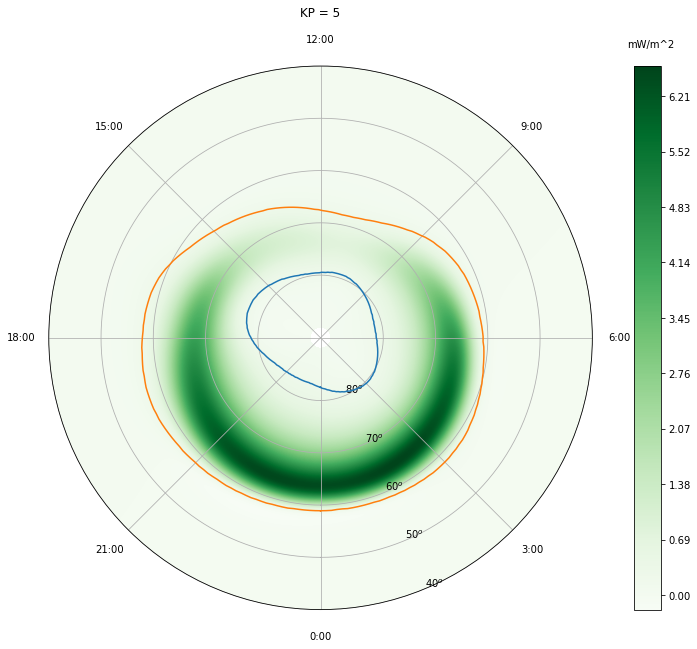

In [11]:
#begin the plot
h = plt.figure(figsize=(15,10))
h.clear() #clears previous figure
h.subplots_adjust(hspace = .5, wspace=.001)

#set up the new figure
#ax = h.add_subplot(2,5,KP+1,projection='polar')
ax = h.add_subplot(111,projection='polar')
ax.set_theta_zero_location('S')
theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
ax.set_thetagrids(theta_label_values,labels=theta_labels)
r_label_values = 90.-np.array([80.,70.,60.,50.,40.])
r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
   
#get axis at a stable place
#set max and mins
ax.set_ylim(-2,2) # i have no clue why this works 
ax.set_rgrids(r_label_values,labels=r_labels)

origin = 'lower'

#convert localtime to radians for plotting
theta = localTimes/24 * 2 *np.pi

#make a grid for contour plotting
LocalTime, Colatitudes = np.meshgrid(theta, colatitudes) 

#use contour plot function
CS = plt.contourf(LocalTime, Colatitudes, bigQ, 500,
                  cmap=plt.cm.get_cmap("Greens"),
                  origin=origin)

cbar = plt.colorbar(CS)
cbar.set_label('mW/m^2', labelpad=-40, y=1.05, rotation=0)
plotTwoTitle = ('KP = %d'%(KP))
plt.title(plotTwoTitle, y=1.08)
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 22}

matplotlib.rc('font', **font) 
#plot the boundary on the contour 
mappable = ax.plot(theta,polewardBound)
mappable = ax.plot(theta,equatwardBound)

plt.show()
